# Introduction

In this project, I built a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
from torch.utils.data import DataLoader

## Loading the Dataset



In [3]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor()])

# Create training set and define training dataloader
train_data = datasets.MNIST(root="data", train=True, download=False, transform=transform)
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

# Create test set and define test dataloader
test_data = datasets.MNIST(root="data", train=False, download=False, transform=transform)

test_set, val_set = torch.utils.data.random_split(test_data, [5000, 5000])

In [4]:
test_loader = DataLoader(test_set, batch_size=100, shuffle=False)
val_loader = DataLoader(val_set, batch_size=100, shuffle=False)

## Justification for the preprocessing



The MNIST dataset is an image dataset and before we can work with an image data set in pytorch, it needs to be converted to tensor hence, the need for the `transforms.Compose([transforms.ToTensor()])` command which transforms the data from images to tensor and the `DataLoader` shuffles the data for training and provides it to the model in batches while the `random_split` method splits the test data into validation and test sets.

## Exploring the Dataset
Using matplotlib, numpy, and torch, we can explore the dimensions of your data.

We can view images using the `show5` function defined below – it takes a data loader as an argument

In [5]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

5


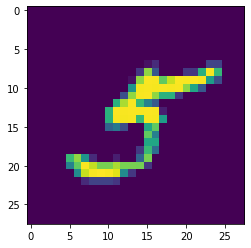

4


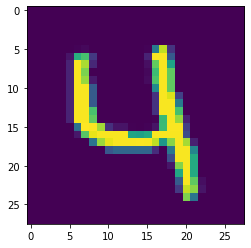

0


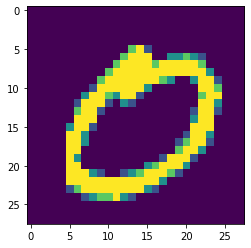

6


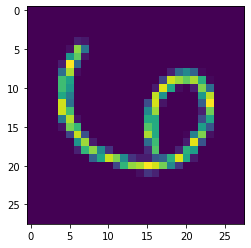

3


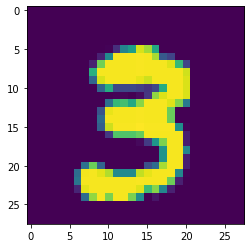

In [6]:
# Explore data
show5(train_loader)

## Building the Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), we can construct a neural network based on the parameters of the dataset.

In [7]:
input_size = 28*28
num_classes = 10

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [18]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = torch.flatten(xb, 1) # flatten all dimensions except batch
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'train_loss': loss, 'train_acc': acc}
        
    def training_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['train_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def train_epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}".format(epoch, result['train_loss'], result['train_acc']))

    def val_epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

In [23]:
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

torch.Size([100, 1, 28, 28])
outputs.shape :  torch.Size([100, 10])
Sample outputs :
 tensor([[-0.1287,  0.2651, -0.0036,  0.2949,  0.4563,  0.1753,  0.2856,  0.1520,
         -0.2446,  0.1246],
        [ 0.0363,  0.1971, -0.1237,  0.4033,  0.3938,  0.0698,  0.2079, -0.0719,
          0.0347,  0.0148]])


## Running the Neural Network


In [9]:
def evaluate_train(model, train_loader):
    outputs = [model.training_step(batch) for batch in train_loader]
    return model.training_epoch_end(outputs)

def evaluate_val(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [19]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            result = model.training_step(batch)
            result["train_loss"].backward()
            optimizer.step()
            optimizer.zero_grad()

        result0 = evaluate_train(model, train_loader)
        model.train_epoch_end(epoch, result0)
        history.append(result0)
        
        # Validation phase
        result1 = evaluate_val(model, val_loader)
        model.val_epoch_end(epoch, result1)
        history.append(result1)

    return history

In [23]:
history = fit(20, 0.001, model, train_loader, val_loader)

Epoch [0], train_loss: 1.1070, train_acc: 0.8095
Epoch [0], val_loss: 1.0818, val_acc: 0.8258
Epoch [1], train_loss: 1.0027, train_acc: 0.8204
Epoch [1], val_loss: 0.9756, val_acc: 0.8352
Epoch [2], train_loss: 0.9247, train_acc: 0.8286
Epoch [2], val_loss: 0.8961, val_acc: 0.8424
Epoch [3], train_loss: 0.8641, train_acc: 0.8343
Epoch [3], val_loss: 0.8345, val_acc: 0.8482
Epoch [4], train_loss: 0.8158, train_acc: 0.8388
Epoch [4], val_loss: 0.7852, val_acc: 0.8536
Epoch [5], train_loss: 0.7761, train_acc: 0.8427
Epoch [5], val_loss: 0.7449, val_acc: 0.8576
Epoch [6], train_loss: 0.7431, train_acc: 0.8468
Epoch [6], val_loss: 0.7114, val_acc: 0.8600
Epoch [7], train_loss: 0.7150, train_acc: 0.8497
Epoch [7], val_loss: 0.6830, val_acc: 0.8630
Epoch [8], train_loss: 0.6908, train_acc: 0.8519
Epoch [8], val_loss: 0.6584, val_acc: 0.8670
Epoch [9], train_loss: 0.6698, train_acc: 0.8542
Epoch [9], val_loss: 0.6370, val_acc: 0.8680
Epoch [10], train_loss: 0.6513, train_acc: 0.8564
Epoch [10]

In [80]:
history

[{'train_loss': 0.5310081243515015, 'train_acc': 0.8707500100135803},
 {'val_loss': 0.5061314105987549, 'val_acc': 0.8829999566078186},
 {'train_loss': 0.5247629284858704, 'train_acc': 0.8718833327293396},
 {'val_loss': 0.5000216960906982, 'val_acc': 0.8833999633789062},
 {'train_loss': 0.5188950300216675, 'train_acc': 0.8727165460586548},
 {'val_loss': 0.4942259192466736, 'val_acc': 0.8835999369621277},
 {'train_loss': 0.5133684873580933, 'train_acc': 0.8736333250999451},
 {'val_loss': 0.48880496621131897, 'val_acc': 0.8841999769210815},
 {'train_loss': 0.508156955242157, 'train_acc': 0.8741500973701477},
 {'val_loss': 0.4836615324020386, 'val_acc': 0.8849999308586121},
 {'train_loss': 0.5032294392585754, 'train_acc': 0.8748832941055298},
 {'val_loss': 0.4789188504219055, 'val_acc': 0.885200023651123},
 {'train_loss': 0.49855899810791016, 'train_acc': 0.8758166432380676},
 {'val_loss': 0.474338173866272, 'val_acc': 0.8851999640464783},
 {'train_loss': 0.49412810802459717, 'train_acc':

In [83]:
train_loss = [history[i]["train_loss"] for i in range(0, 40, 2)]
train_loss

[0.5310081243515015,
 0.5247629284858704,
 0.5188950300216675,
 0.5133684873580933,
 0.508156955242157,
 0.5032294392585754,
 0.49855899810791016,
 0.49412810802459717,
 0.48991596698760986,
 0.48590973019599915,
 0.48208343982696533,
 0.47843077778816223,
 0.4749395251274109,
 0.4715965688228607,
 0.46839430928230286,
 0.4653201401233673,
 0.4623640477657318,
 0.4595235586166382,
 0.4567878842353821,
 0.45415282249450684]

In [84]:
val_loss = [history[i]["val_loss"] for i in range(1, 41, 2)]
val_loss

[0.5061314105987549,
 0.5000216960906982,
 0.4942259192466736,
 0.48880496621131897,
 0.4836615324020386,
 0.4789188504219055,
 0.474338173866272,
 0.46997082233428955,
 0.46584832668304443,
 0.4618934392929077,
 0.45823708176612854,
 0.4545935392379761,
 0.4512375295162201,
 0.44797348976135254,
 0.4448576271533966,
 0.44182923436164856,
 0.4389459490776062,
 0.4361838400363922,
 0.4335228204727173,
 0.4309626519680023]

Plotting the training loss against validation loss/accuracy.

In [86]:
import matplotlib.pyplot as plt

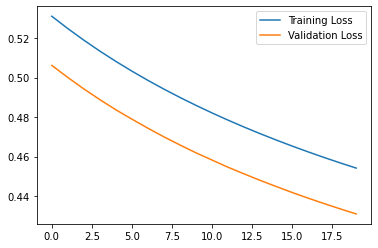

In [87]:
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend()
plt.show()

## Testing the model

In [88]:
result = evaluate_val(model, test_loader)
result

{'val_loss': 0.43364474177360535, 'val_acc': 0.886400043964386}

## Improving the model

Increasing the number of epochs

In [89]:
fit(30, 0.001, model, train_loader, val_loader)

Epoch [0], train_loss: 0.4516, train_acc: 0.8835
Epoch [0], val_loss: 0.4285, val_acc: 0.8918
Epoch [1], train_loss: 0.4492, train_acc: 0.8840
Epoch [1], val_loss: 0.4261, val_acc: 0.8920
Epoch [2], train_loss: 0.4468, train_acc: 0.8843
Epoch [2], val_loss: 0.4238, val_acc: 0.8928
Epoch [3], train_loss: 0.4445, train_acc: 0.8846
Epoch [3], val_loss: 0.4215, val_acc: 0.8932
Epoch [4], train_loss: 0.4423, train_acc: 0.8851
Epoch [4], val_loss: 0.4194, val_acc: 0.8934
Epoch [5], train_loss: 0.4401, train_acc: 0.8856
Epoch [5], val_loss: 0.4173, val_acc: 0.8938
Epoch [6], train_loss: 0.4381, train_acc: 0.8860
Epoch [6], val_loss: 0.4153, val_acc: 0.8940
Epoch [7], train_loss: 0.4361, train_acc: 0.8864
Epoch [7], val_loss: 0.4134, val_acc: 0.8940
Epoch [8], train_loss: 0.4341, train_acc: 0.8868
Epoch [8], val_loss: 0.4115, val_acc: 0.8946
Epoch [9], train_loss: 0.4322, train_acc: 0.8872
Epoch [9], val_loss: 0.4096, val_acc: 0.8950
Epoch [10], train_loss: 0.4304, train_acc: 0.8874
Epoch [10]

[{'train_loss': 0.4516122043132782, 'train_acc': 0.8834999799728394},
 {'val_loss': 0.4284623861312866, 'val_acc': 0.8918001055717468},
 {'train_loss': 0.44916239380836487, 'train_acc': 0.8839666843414307},
 {'val_loss': 0.4261428713798523, 'val_acc': 0.8919999599456787},
 {'train_loss': 0.4467918276786804, 'train_acc': 0.8843000531196594},
 {'val_loss': 0.42378225922584534, 'val_acc': 0.892799973487854},
 {'train_loss': 0.44450363516807556, 'train_acc': 0.884600043296814},
 {'val_loss': 0.42152637243270874, 'val_acc': 0.8932000994682312},
 {'train_loss': 0.44228801131248474, 'train_acc': 0.8850666284561157},
 {'val_loss': 0.4193544387817383, 'val_acc': 0.8934000134468079},
 {'train_loss': 0.44014227390289307, 'train_acc': 0.8855500221252441},
 {'val_loss': 0.41730058193206787, 'val_acc': 0.8937999606132507},
 {'train_loss': 0.4380638003349304, 'train_acc': 0.8859667181968689},
 {'val_loss': 0.41529545187950134, 'val_acc': 0.8939999938011169},
 {'train_loss': 0.4360509216785431, 'train

## Saving the model
Using `torch.save` to save the model for future loading.

In [90]:
torch.save(model.state_dict(), 'model/mnist-logistic.pth')